In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate
import os
import cartopy

cartopy_version = cartopy.__version__
if int(cartopy_version.split('.')[0]) < 1 and int(cartopy_version.split('.')[1]) < 18:
    print(f"WARNING: cartopy versions below 0.18 don't support some key plotting features for stereographic projections. You have version {cartopy_version}.")
    # If you get this warning, you'll probably want to update to 0.18 or higher.

This is a quick reference (mostly written for myself) for loading a few common NetCDF-format continent-wide Antarctic datasets. This notebook will produce these plots:

![MEaSURE Velocities](surfacevelocity.png) ![Surface Mass Balances](smb.png) ![BedMachine Ice Thicknesses](bedmachinethickness.png)

A minimal set of package you'll need can be installed with:

```conda install -c conda-forge netcdf4 matplotlib numpy scipy cartopy```

# Loading data
### Loading common NetCDF-format Antarctic datasets in Python

If you're a MATLAB user, Antarctic Mapping Tools provides easy access to this sort of data. Unfortunatley, no equivalent exists (to my knowledge) for other langauges.

https://www.mathworks.com/matlabcentral/fileexchange/47638-antarctic-mapping-tools

This is mostly meant as a reference for myself, but hopefully it'll be helpful to others too. Below are simple examples of how to load three common Antarctic datasets:

* MEaSUREs InSAR Surface Velocities

  https://nsidc.org/data/NSIDC-0754/versions/1
  
  InSAR-dervied surface velocities across Antarctica at a spatial resolution of 450 m.
  
* BedMachine Antarctica Basal Topography

  https://nsidc.org/data/NSIDC-0756/versions/1
  
  Basal topography at a 500 m resolution inferred from a variety of methods, including mass conservation in fast-flowing areas.
  
* RACMO3.2p2 Modelled Surface Mass Balances

  https://www.projects.science.uu.nl/iceclimate/publications/data/2018/vwessem2018_tc/RACMO_Yearly/
  
  https://tc.copernicus.org/articles/12/1479/2018/
  
  Estimated surface mass balances based on the RACMO3.2p2 climate model. **Use caution with the units here. See notes below and also:**
  
  https://www.nature.com/articles/nature24478.pdf

In [3]:
data_dir = '/home/thomas/Downloads/' # don't do this :p

nc_measure = Dataset(os.path.join(data_dir, 'antarctica_ice_velocity_450m_v2.nc'))
nc_bedmachine = Dataset(os.path.join(data_dir, 'BedMachineAntarctica_2019-11-05_v01.nc'))
nc_smb_racmo = Dataset(os.path.join(data_dir, 'SMB_RACMO2.3p2_yearly_ANT27_1979_2016.nc'))
nc_t2m_ecmwf = Dataset(os.path.join(data_dir, 'adaptor.mars.internal-1596499403.230529-10910-15-b75c989d-f3e2-45ac-920c-aa0d870b665e.nc'))

Each of these `Dataset`s is annotated with information about the various fields. You can see all of the field sizes and metadata like this:

> `nc_measure.variables`

For example, the `VX` field of the MEaSURE dataset looks like this:

> ```
'VY': <class 'netCDF4._netCDF4.Variable'>
 float32 VY(y, x)
     long_name: Ice velocity in y direction
     standard_name: land_ice_y_velocity
     units: meter/year
     _FillValue: 0.0
     coordinates: lon lat
     grid_mapping: coord_system
 unlimited dimensions: 
 current shape = (12445, 12445)
 filling on,
 ```

In [4]:
#nc_measure.variables

# Plotting data

### Plotting BedMachine data

The BedMachine dataset provides data in a polar stereographic projection. Specifically, from the BedMachine data website:

> "The projection is Polar Stereographic South (71ºS, 0ºE), which corresponds to ESPG 3031"
> https://sites.uci.edu/morlighem/dataproducts/bedmachine-antarctica/

EPSG codes are standardized coordinate references systems designed to make it do things like what we're doing here. You can learn about EPSG 3031 here: https://epsg.io/3031

First, we need to define the projection. In theory, we should be able to define it directly from the EPSG code like this:

```crs_3031 = cartopy.crs.epsg(3031)```

I'm not sure why, but this doesn't work right now (as of Cartopy 0.18.0). So instead, we define the same coordinate reference system manually.

Thanks to the Cartopy interface, the rest is pretty much like plotting any data in matplotlib.

BedMachine provides `x` and `y` vectors, corresponding to projected coordinates, and 2D matrices containing various values. In order to plot this with `pcolormesh` we create two 2D grids with all the associated X and Y values using `np.meshgrid`.

Because this data is extremely dense (450 m grid), we downsample it by 50 before plotting so this won't take forever.

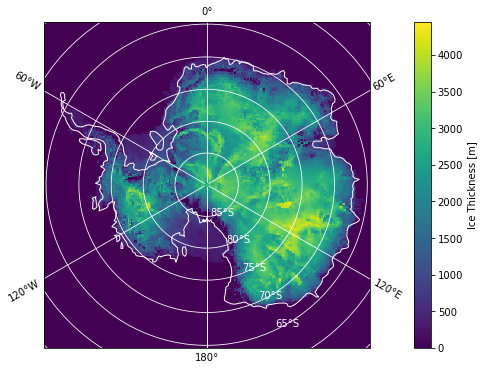

In [5]:
crs_3031 = cartopy.crs.Stereographic(central_latitude=-90, true_scale_latitude=-71)

fig, ax = plt.subplots(figsize=(8,6), facecolor='white', subplot_kw=dict(projection=crs_3031)) # Create our plot

ax.coastlines(resolution='110m', color='white') # Add coastlines
gl = ax.gridlines(draw_labels=True, color='white') # Add gridlines to make latitudes/longitudes
gl.ylabel_style = {'color': 'white'} # The latitudes are shown inside the plot, so they need to be white for visibility

n = 50 # Downsampling factor
X_bm, Y_bm = np.meshgrid(nc_bedmachine.variables['x'][::n], nc_bedmachine.variables['y'][::n])
h = np.array(nc_bedmachine.variables['thickness'])[::n,::n]

pcm = ax.pcolormesh(X_bm, Y_bm, h) # Plot thickness data
clb = fig.colorbar(pcm, ax=ax, pad=0.1) # Add a colorbar
clb.set_label('Ice Thickness [m]')

ax.set_aspect('equal')
ax.set_xlim(-2.8e6,2.8e6) # Quick note here: If you use set_(x/y)lim, you're setting the limits in projected coordinates.
ax.set_ylim(-2.8e6,2.8e6) #                  If you prefer, you can use ax.set_extent to set the limits in any coordinate system you want.

#plt.savefig('bedmachinethickness.png')

plt.show()

That's a bit of a mouthful, so I wrote a helper function (check out `plot_util.py`) to handle most of it for you. The only additional fancy thing it's doing is interpreting categorical variables (such as the ice mask). Check out the function to see how that works.

BedMachine also has several other data fields we might be interested in plotting:

Note: All of the keys you can try are: ['mask', 'firn', 'surface', 'thickness', 'bed', 'errbed', 'source', 'geoid']


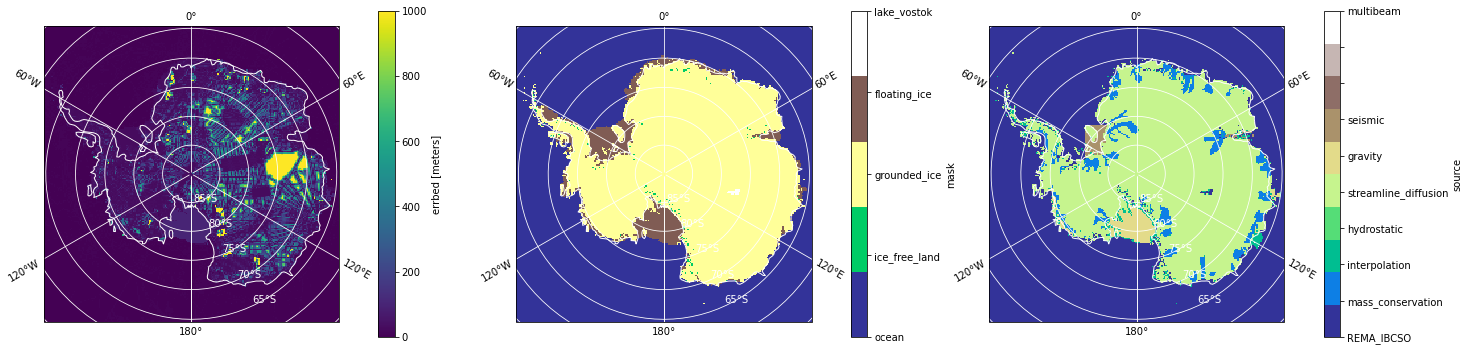

In [6]:
# This is just a filter to display only keys in the dataset that are 2-dimensional. 1D and 0D fields don't make sense to plot.
print(f"Note: All of the keys you can try are: {[x for x in nc_bedmachine.variables.keys() if len(nc_bedmachine[x].shape) == 2]}")

plot_keys = ['errbed', 'mask', 'source']

fig, axs = plt.subplots(1, len(plot_keys), figsize=(8*len(plot_keys),6), facecolor='white', subplot_kw=dict(projection=crs_3031))

for key, ax in zip(plot_keys, axs):
    ax.coastlines(resolution='110m', color='white') # Add coastlines
    gl = ax.gridlines(draw_labels=True, color='white') # Add gridlines to make latitudes/longitudes
    gl.ylabel_style = {'color': 'white'} # The latitudes are shown inside the plot, so they need to be white for visibility

    n = 50 # Downsampling factor
    X_bm, Y_bm = np.meshgrid(nc_bedmachine.variables['x'][::n], nc_bedmachine.variables['y'][::n])
    vals = np.array(nc_bedmachine.variables[key])[::n,::n]

    # In order to disply a reasonable colorbar, we need to know if this is categorical data or scalar data
    if 'flag_meanings' in nc_bedmachine.variables[key].ncattrs(): # Categorical data
        color_key = {k: v for k, v in zip(nc_bedmachine.variables[key].flag_values,
                                          nc_bedmachine.variables[key].flag_meanings.split())}
        
        cat_min = np.min(nc_bedmachine.variables[key].flag_values)
        cat_max = np.max(nc_bedmachine.variables[key].flag_values)
        cat_ticks = list(range(cat_min, cat_max+1))
        cat_tick_labels = [color_key.get(x, "") for x in cat_ticks]
        
        pcm = ax.pcolormesh(X_bm, Y_bm, vals,
                            vmin=cat_min,
                            vmax=cat_max,
                            cmap=plt.cm.get_cmap('terrain', cat_max-cat_min+1))
        
        clb = fig.colorbar(pcm, ax=ax, ticks=cat_ticks, pad=0.1) # Add a colorbar
        clb.ax.set_yticklabels(cat_tick_labels)
        clb.set_label(key)
    else: # Scalar data
        if key == 'errbed':
            pcm = ax.pcolormesh(X_bm, Y_bm, vals, vmin=0) # Plot data
        else:
            pcm = ax.pcolormesh(X_bm, Y_bm, vals) # Plot data
        clb = fig.colorbar(pcm, ax=ax, pad=0.1) # Add a colorbar
        clb.set_label(f"{key} [{nc_bedmachine.variables[key].units}]")

    ax.set_aspect('equal')
    ax.set_xlim(-2.8e6,2.8e6) # Quick note here: If you use set_(x/y)lim, you're setting the limits in projected coordinates.
    ax.set_ylim(-2.8e6,2.8e6) #                  If you prefer, you can use ax.set_extent to set the limits in any coordinate system you want.

plt.show()

### Plotting MEaSURE data

Plotting the MEaSURE dataset isn't too different. The projection is the same as BedMachine, so no changes are needed there.

The primary data fields are `VX` and `VY`, representing components of the surface velocity vector in the projection. To plot the magnitude, we just do `sqrt(vx**2 + vy**2)`. (For MATLAB-folk out there, `**` is the exponent operator in Python.)

Since this is a vector field, we can also add some arrows to show the direction. This is pretty straightforward with a simple call to `quiver`.

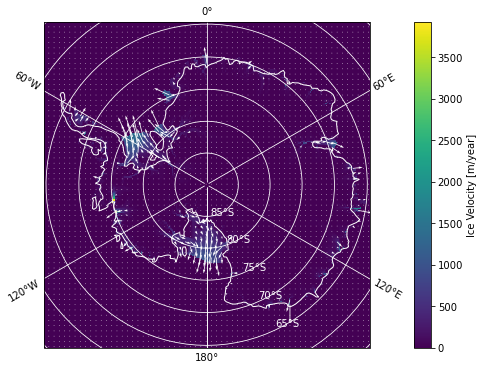

In [7]:
crs_3031 = cartopy.crs.Stereographic(central_latitude=-90, true_scale_latitude=-71)

fig, ax = plt.subplots(figsize=(8,6), facecolor='white', subplot_kw=dict(projection=crs_3031)) # Create our plot

ax.coastlines(resolution='110m', color='white') # Add coastlines
gl = ax.gridlines(draw_labels=True, color='white') # Add gridlines to make latitudes/longitudes
gl.ylabel_style = {'color': 'white'} # The latitudes are shown inside the plot, so they need to be white for visibility

n = 50 # Downsampling factor
X_measure, Y_measure = np.meshgrid(nc_measure.variables['x'][::n], nc_measure.variables['y'][::n])
vx = np.array(nc_measure.variables['VX'])[::n,::n]
vy = np.array(nc_measure.variables['VY'])[::n,::n]
v_mag = np.sqrt(vx**2 + vy**2)

pcm = ax.pcolormesh(X_measure, Y_measure, v_mag) # Plot thickness data
clb = fig.colorbar(pcm, ax=ax, pad=0.1) # Add a colorbar
clb.set_label('Ice Velocity [m/year]')

# Add arrows to indicate direction
arrow_subsample = 4
ax.quiver(X_measure[::arrow_subsample,::arrow_subsample],
          Y_measure[::arrow_subsample,::arrow_subsample],
          vx[::arrow_subsample,::arrow_subsample],
          vy[::arrow_subsample,::arrow_subsample],
          angles='xy', color='white', scale=2e4)
# Unfortunately, it usually takes some tweaking of `scale` and `arrow_subsample` to get a readable vector field

ax.set_aspect('equal')
ax.set_xlim(-2.8e6,2.8e6) # Quick note here: If you use set_(x/y)lim, you're setting the limits in projected coordinates.
ax.set_ylim(-2.8e6,2.8e6) #                  If you prefer, you can use ax.set_extent to set the limits in any coordinate system you want.

#plt.savefig('surfacevelocity.png')

plt.show()

### Plotting RACMO data

The RACMO data comes in pretty much the same format, so there's not much different here. One note is that this dataset contains details for multiple years. For our purposes, we'll average across the years.

Another very important note is that the units in the surface mass balance dataset appear to be incorrect. The metadata gives units of `kg m-2 s-1`, however these numbers don't make sense. Treating this variable as if it had a unit of kilograms per meter squared per **year** produces values that make sense.

For the plot below, we divide this number by 900 kg / m^3 to produce an approximate ice-equivalent thickness change from surface mass balance.

In [8]:
nc_smb_racmo.variables['smb'] # Note the 'units' field here

<class 'netCDF4._netCDF4.Variable'>
float32 smb(time, height, rlat, rlon)
    _FillValue: -9999.0
    cell_methods: time: 24-hr averaged values
    coordinates: lon lat
    grid_mapping: rotated_pole
    long_name:  Surface Mass Balance ice sheet
    standard_name: smb
    units: kg m-2 s-1
unlimited dimensions: time
current shape = (38, 1, 240, 262)
filling on

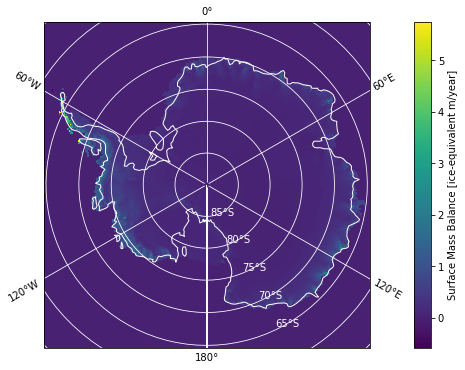

In [9]:
crs_lonlat = cartopy.crs.PlateCarree()

fig, ax = plt.subplots(figsize=(8,6), facecolor='white', subplot_kw=dict(projection=crs_3031)) # Note: our plot will still be in EPSG3031

ax.coastlines(resolution='110m', color='white') # Add coastlines
gl = ax.gridlines(draw_labels=True, color='white') # Add gridlines to make latitudes/longitudes
gl.ylabel_style = {'color': 'white'} # The latitudes are shown inside the plot, so they need to be white for visibility

# Note: no need to downsample - this is already pretty low-res
lat_racmo = np.array(nc_smb_racmo['lat'])
lon_racmo = np.array(nc_smb_racmo['lon'])
smb_racmo = np.array(nc_smb_racmo['smb'])
smb_racmo_avg = np.mean(smb_racmo[:,0,:,:], axis=0) # Time average over all years in the dataset

pcm = ax.pcolormesh(lon_racmo, lat_racmo, smb_racmo_avg / 900, transform=crs_lonlat) # Plot thickness data
clb = fig.colorbar(pcm, ax=ax, pad=0.1) # Add a colorbar
clb.set_label('Surface Mass Balance [ice-equivalent m/year]')

ax.set_aspect('equal')
ax.set_xlim(-2.8e6,2.8e6) # Quick note here: If you use set_(x/y)lim, you're setting the limits in projected coordinates.
ax.set_ylim(-2.8e6,2.8e6) #                  If you prefer, you can use ax.set_extent to set the limits in any coordinate system you want.

#lt.savefig('smb.png')

plt.show()

### Plotting ECMWF temperature data

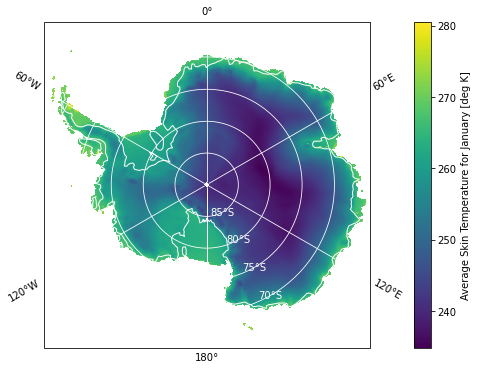

In [10]:
fig, ax = plt.subplots(figsize=(8,6), facecolor='white', subplot_kw=dict(projection=crs_3031)) # Note: our plot will still be in EPSG3031

ax.coastlines(resolution='110m', color='white') # Add coastlines
gl = ax.gridlines(draw_labels=True, color='white') # Add gridlines to make latitudes/longitudes
gl.ylabel_style = {'color': 'white'} # The latitudes are shown inside the plot, so they need to be white for visibility

lat_ecmwf = np.array(nc_t2m_ecmwf['latitude'])
lon_ecmwf = np.array(nc_t2m_ecmwf['longitude'])
skt_ecmwf = np.array(nc_t2m_ecmwf['skt'])
skt_ecmwf_avg = np.mean(skt_ecmwf, axis=0) # Time average over all years in the dataset

m = np.ma.masked_where(skt_ecmwf_avg == -32767, skt_ecmwf_avg) # -32767 is a fill value indiciating no data

pcm = ax.pcolormesh(lon_ecmwf, lat_ecmwf, m, transform=crs_lonlat) # Plot thickness data
clb = fig.colorbar(pcm, ax=ax, pad=0.1) # Add a colorbar
clb.set_label('Average Skin Temperature for January [deg K]')

ax.set_aspect('equal')
ax.set_xlim(-2.8e6,2.8e6) # Quick note here: If you use set_(x/y)lim, you're setting the limits in projected coordinates.
ax.set_ylim(-2.8e6,2.8e6) #                  If you prefer, you can use ax.set_extent to set the limits in any coordinate system you want.

#plt.savefig('temperature.png')

plt.show()